# Preprocessing of  2P calcium imaging data
* motion correction
* manual (or automatic)  mask generation for rough region of interest
* automatic generation of region of interests based on k-means clustering

In [1]:
from skimage.io import imread, imshow
from matplotlib import pyplot as plt
import matplotlib.colors as colors
import numpy as np
from sys import path
from os.path import sep, exists
from os import mkdir, makedirs, getcwd

from scipy.ndimage.filters import gaussian_filter

from sklearn.cluster import KMeans

from scipy.signal import savgol_filter

import flika as flk
from flika.window import Window as flw

%matplotlib inline

from roiVisualization import myAxisTheme
from imagingPreProc import metadatFromTiff, motionCorrSinglePlane

In [106]:
tiffName = 'SS52577_GCaMP7b_f05_6-7d_FB_groundPl_00002.tif'
subdir =  ''

[driver, effector, flyID, age, region, condition, trial] = tiffName.split('_')
trial = int(trial[-5:-4])
genotype = driver + '_x_'  + effector
print(driver, effector, flyID, age, region, condition, trial)

SS52577 GCaMP7b f05 6-7d FB groundPl 2


In [107]:
rootDir = sep.join(['/Users/haberkernh/Desktop/PathInteg_withDan',effector+'_x_'+driver,subdir])
dataDir = sep.join([rootDir,'rawData','imaging',flyID])
saveDir = rootDir+sep+'preprocData/autoROI'
if not exists(saveDir): makedirs(saveDir)
print(dataDir)
print(saveDir)

/Users/haberkernh/Desktop/PathInteg_withDan/GCaMP7b_x_SS52577//rawData/imaging/f05
/Users/haberkernh/Desktop/PathInteg_withDan/GCaMP7b_x_SS52577//preprocData/autoROI


In [108]:
# load imaging data
rawstack = imread(dataDir +sep+ tiffName)
stackshape = rawstack.shape
print(stackshape)

# get stack parameter
nCh, discardFBFrames, nDiscardFBFrames, fpsscan, fpv, nVols = metadatFromTiff(dataDir, tiffName) 

(10800, 256, 256)
b"SI.VERSION_COMMIT = 'ca9e5a08f36348e2a0551efd86341b8fec5367fd'"
b"SI.VERSION_MAJOR = '2019a'"
b"SI.VERSION_MINOR = '1'"
b'SI.hChannels.channelSave = 2'
b'SI.hFastZ.discardFlybackFrames = true'
b'SI.hFastZ.numDiscardFlybackFrames = 2'
b'SI.hFastZ.numFramesPerVolume = 12'
b'SI.hFastZ.numVolumes = 900'
b'SI.hRoiManager.scanFrameRate = 85.5826'
 # channels: 1
 fly back?  true
 # discard frames: 2
 # frames/volume: 12
 # volumes: 900


In [109]:
caCh = nCh-1
vps =  fpsscan/fpv #volumes per second = fpv / fpsscan
print('frame rate per volume [Hz]: {}'.format(vps))

frame rate per volume [Hz]: 7.131883333333334


In [110]:
rawstack = rawstack.reshape((int(stackshape[0]/(fpv*nCh)),fpv,nCh,stackshape[1], stackshape[2]))
print('Full dimensional stack: rawstack')
print(rawstack.shape)

stack4d = np.squeeze(rawstack[:,0:-nDiscardFBFrames,caCh,:,:])
print('Stack reduced to one color channel and flyback frames discrded: stack4d')
print(stack4d.shape)

Full dimensional stack: rawstack
(900, 12, 1, 256, 256)
Stack reduced to one color channel and flyback frames discrded: stack4d
(900, 10, 256, 256)


In [111]:
# max projected stack
stackMP = stack4d.max(axis=1)
stackMP.shape

(900, 256, 256)

### Motion correction

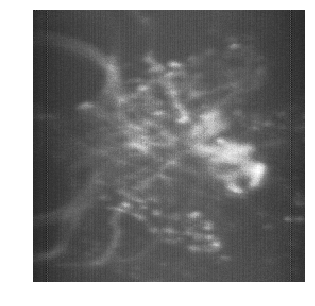

In [112]:
## registration settings
upsampleFactor = 100

# Generate reference image
refImg = np.mean(stackMP[50:,:,:],axis=0)

fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.imshow(refImg,cmap='Greys_r', vmin=0,origin='upper')
ax.axis('off');

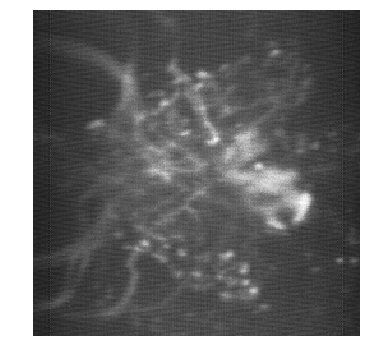

In [113]:
stackMPMC = motionCorrSinglePlane(stackMP, refImg, upsampleFactor, gaussianFiltRef = False)

refImgMC = np.mean(stackMPMC,axis=0)

fig, ax = plt.subplots(1,1,figsize=(6,6))
ax.imshow(refImgMC,cmap='Greys_r', vmin=0,origin='upper')
ax.axis('off')
fig.savefig(saveDir+sep+tiffName[:-4]+'_refImg.pdf')

### Motion correction on volume

In [10]:
flk.start_flika()

Starting flika


Starting flika inside IPython


In [11]:
# Generate reference stack

## registration settings
upsampleFactor = 100

# Generate reference image
refStack = np.mean(stack4d,axis=0)

In [12]:
flk.start_flika()
refStackWnd = flw(refStack)

Starting flika
flika menubar already initialized.
Starting flika inside IPython


In [58]:
# Perform volume motion correction as follows:
# - compute required shift on max projection
# - then perform shift on each plane separately

In [14]:
def motionCorrVol(stack4d, refStack, upsampleFactor, gaussianFiltRef = False):
    
    from skimage.feature import register_translation
    from scipy.ndimage import fourier_shift
    from scipy.ndimage.filters import gaussian_filter

    stack4dMC = np.ones(stack4d.shape).astype('int16')
    
    numPlanes = stack4d.shape[1]
    # perform motion correction per plane
    for p in range(numPlanes):
        refImg = refStack[p,:,:].squeeze()
        
        shift = np.zeros((2, stack4d.shape[0]))
        error = np.zeros(stack4d.shape[0])
        diffphase = np.zeros(stack4d.shape[0])
        
        if gaussianFiltRef:
            refImg = gaussian_filter(refImg, sigma=2)

        for i in range(stack4d.shape[0]):
            shifImg = stack4d[i,p,:,:]

            # subpixel precision
            shift[:,i], error[i], diffphase[i] = register_translation(refImg, shifImg, upsampleFactor)

            offset_image = fourier_shift(np.fft.fftn(shifImg), shift[:,i])
            stack4dMC[i,p,:,:] = np.fft.ifftn(offset_image).real.astype('uint16')

    return stack4dMC

In [15]:
stack4dMC = motionCorrVol(stack4d[:100,:,:,:], refStack, upsampleFactor, gaussianFiltRef = False)

In [16]:
stack4dMC.shape

(100, 10, 256, 256)

In [17]:
toVisStack4dMC = stack4dMC.reshape(stack4dMC.shape[0],stack4dMC.shape[1]*stack4dMC.shape[2],stack4dMC.shape[3])
toVisStack4dMC.shape

(100, 2560, 256)

In [18]:
refStackWnd = flw(toVisStack4dMC)

/Users/haberkernh/anaconda3/lib/python3.6/site-packages/pyqtgraph/imageview/ImageView.py:588: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  data = data[sl]


(-0.5, 2559.5, 255.5, -0.5)

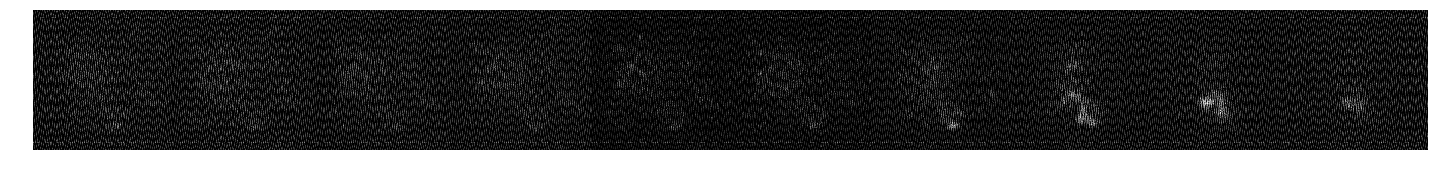

In [19]:
refImgMC = np.mean(toVisStack4dMC,axis=0).T

fig, ax = plt.subplots(1,1,figsize=(25,5))
ax.imshow(refImgMC,cmap='Greys_r', vmin=0,origin='upper')
ax.axis('off')

(-0.5, 255.5, 255.5, -0.5)

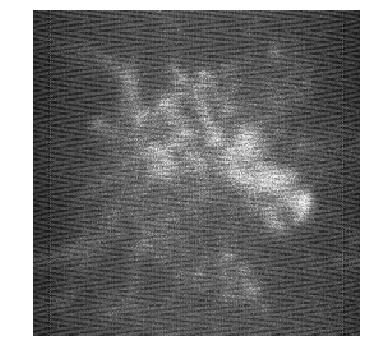

In [20]:
refImgMCVol = np.mean(np.max(stack4dMC,axis=1),axis=0)

fig, ax = plt.subplots(1,1,figsize=(6,6))
ax.imshow(refImgMC,cmap='Greys_r', vmin=0,origin='upper')
ax.axis('off')

## ROI detection based on k-means clustering

### (1) Define regions on which to perform clustering

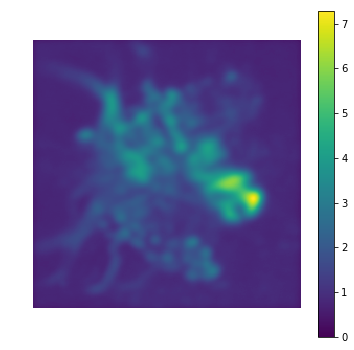

In [27]:
varPx = np.std(gaussian_filter(stackMPMC, sigma=[0,4,4],mode='constant'), axis=0)

fig, ax = plt.subplots(1,1,figsize=(6,6))
cb = ax.imshow(varPx,cmap='viridis', vmin=0,origin='upper')
ax.axis('off')
plt.colorbar(cb)

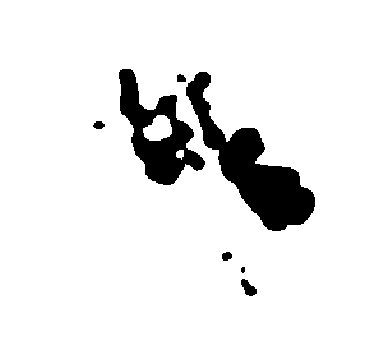

In [28]:
varTh = 2.5#2
mask  = (np.logical_and(varPx>varTh, gaussian_filter(refImgMC, sigma=[4,4])>10)).astype('int')


fig, ax = plt.subplots(1,1,figsize=(6,6))
ax.imshow(mask,cmap='Greys', vmin=0,origin='upper')
ax.axis('off')

fig.savefig(saveDir+sep+tiffName[:-4]+'_mask.pdf')

#### Draw mask with Flika and process with shapely

In [29]:
from shapely.geometry.polygon import LinearRing, Polygon, LineString
from shapely.geometry.point import Point
import matplotlib.patches as ppatch
import shapely.affinity

In [30]:
maxVidWinMC = flw(refImgMC)

In [31]:
rois = maxVidWinMC.rois
FBouter = LinearRing(rois[0].getPoints())
FBshape = Polygon(rois[0].getPoints())

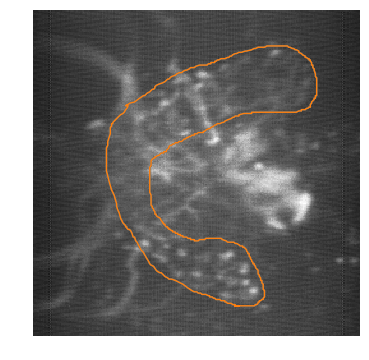

In [32]:
fig, ax = plt.subplots(1,1,figsize=(6,6))
ax.imshow(refImgMC,cmap='Greys_r', vmin=0,origin='upper')
ax.axis('off')

ax.plot(FBouter.coords.xy[1],FBouter.coords.xy[0])
ax.plot(FBshape.boundary.xy[1],FBshape.boundary.xy[0])

In [33]:
#fig, ax = plt.subplots(1,1,figsize=(6,6))
#ax.imshow(refImgMC,cmap='Greys_r', vmin=0,origin='upper')
#ax.axis('off')

#ax.plot(FBouter.coords.xy[1],FBouter.coords.xy[0])
#for x in np.arange(0,refImg.shape[0],5):
#    for y in np.arange(0,refImg.shape[1],5):
#        if FBshape.contains(Point(x,y)):
#            ax.plot(y,x,'.', color='steelblue',markersize=3)

In [34]:
manmask = np.zeros(mask.shape)
for x in np.arange(refImg.shape[0]):
    for y in np.arange(refImg.shape[1]):
        if FBshape.contains(Point(x,y)):
            manmask[x,y] = 1

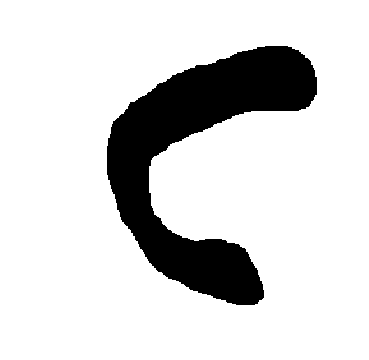

In [35]:
fig, ax = plt.subplots(1,1,figsize=(6,6))
ax.imshow(manmask,cmap='Greys', vmin=0,origin='upper')
ax.axis('off')

fig.savefig(saveDir+sep+tiffName[:-4]+'_manmask.pdf')

### (2) Compute DFF

In [36]:
# filter DF/F trace with Savitzky-Golay filter
# 3rd order, 7 frames

order = 3
window = 7


# Currently F_0 is estimated for the whole time series (ok, if time series is short)
baseLinePercent = 10
offset = 0.0001

myMask = manmask

In [37]:
dffStackMC = np.zeros((stackMPMC.shape)) 

filtStack = gaussian_filter(stackMPMC, sigma=[0,2,2])

for x in range(stackMPMC.shape[1]):
    for y in range(stackMPMC.shape[2]):
        
        if myMask[x,y] == 0:
            continue
            
        filtF = savgol_filter(filtStack[:,x,y], window, order)

        # Estimate baseline
        F0 = np.percentile(filtF, baseLinePercent)
        if F0 == 0: F0 += offset

        # Compute dF/F_0 = (F_raw - F_0)/F_0
        dFF = (filtF - F0) / F0

        dffStackMC[:,x,y] = dFF

/Users/haberkernh/anaconda3/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


(-0.5, 255.5, 255.5, -0.5)

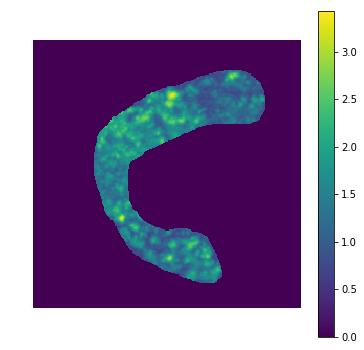

In [38]:
dffMP = np.max(dffStackMC,axis=0)

fig, ax = plt.subplots(1,1,figsize=(6,6))
cb = ax.imshow(dffMP,cmap='viridis',origin='upper')#, vmin=0, vmax=10)
plt.colorbar(cb)
ax.axis('off')

In [39]:
stack4dMC.shape

(100, 10, 256, 256)

In [40]:
#### DFF on volume (use one mask for each plane for now)

dffStack4dMC = np.zeros((stack4dMC.shape)) 

filtStack = gaussian_filter(stack4dMC, sigma=[0,0,2,2])

for x in range(stack4dMC.shape[2]):
    for y in range(stack4dMC.shape[3]):
        for z in range(stack4dMC.shape[1]):
            if myMask[x,y] == 0:
                continue

            filtF = savgol_filter(filtStack[:,z,x,y], window, order)

            # Estimate baseline
            F0 = np.percentile(filtF, baseLinePercent)
            if F0 == 0: F0 += offset

            # Compute dF/F_0 = (F_raw - F_0)/F_0
            dFF = (filtF - F0) / F0

            dffStack4dMC[:,z,x,y] = dFF

(-0.5, 255.5, 255.5, -0.5)

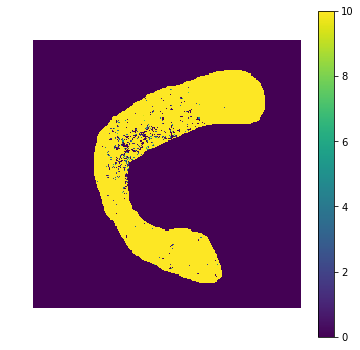

In [41]:
dffMP = np.max(np.mean(dffStack4dMC,axis=1),axis=0)

fig, ax = plt.subplots(1,1,figsize=(6,6))
cb = ax.imshow(dffMP,cmap='viridis',origin='upper', vmin=0, vmax=10)
plt.colorbar(cb)
ax.axis('off')

### (3) Perform clustering on pixels in mask

In [54]:
nclst = 9

toClust = dffStackMC[:,myMask>0]

kmeans = KMeans(n_clusters=nclst)
kmeans.fit(toClust.T)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=9, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [55]:
kmlabs = kmeans.predict(toClust.T)
centroids = kmeans.cluster_centers_

In [56]:
myClstMap = 'tab20b_r'
cNorm  = colors.Normalize(vmin=1, vmax=nclst)
clstCMap = plt.cm.ScalarMappable(norm=cNorm,cmap=myClstMap)

time = np.linspace(0, stackMPMC.shape[0]/fpv, stackMPMC.shape[0])

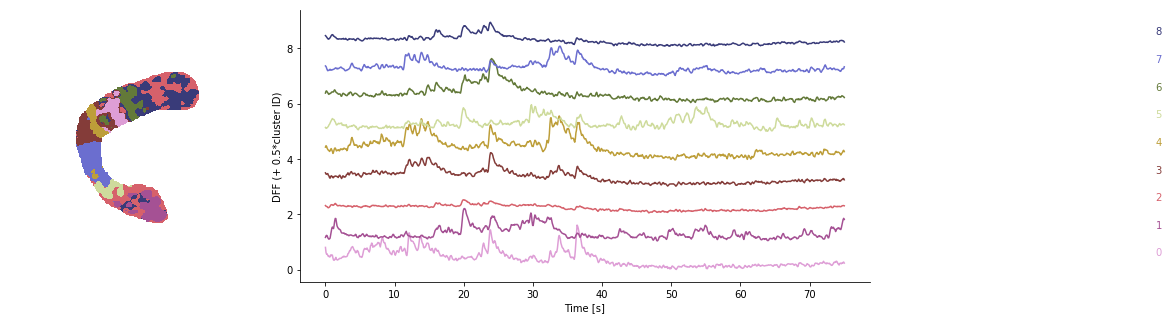

In [57]:
kmlabsImg = np.nan*np.ones(myMask.shape)

kmlabsImg[myMask>0] = kmlabs

fig, axs = plt.subplots(1,2,figsize=(15,5), gridspec_kw={'width_ratios':[1,3]})

axs[0].imshow(kmlabsImg,cmap=myClstMap,origin='upper')
axs[0].axis('off')

for i in range(nclst):
    axs[1].plot(time,centroids[i]+i, color=clstCMap.to_rgba(i+1))
    axs[1].text(120,+i+.5,str(i),color=clstCMap.to_rgba(i+1))
axs[1].set_xlabel('Time [s]')
axs[1].set_ylabel('DFF (+ 0.5*cluster ID)')
myAxisTheme(axs[1])

fig.savefig(saveDir+sep+tiffName[:-4]+'_cluster_n{}.pdf'.format(nclst))

In [58]:
ypos = np.repeat(np.arange(mask.shape[0]),mask.shape[1]).reshape(mask.shape)
yPosClust = np.zeros(nclst)
for i in range(nclst):
    yPosClust[i] = mask.shape[0]-np.median(ypos[kmlabsImg==i])
    print('cluster: {} \t meanpos: {}'.format(i,yPosClust[i]))
    
centroidPerm = np.argsort(yPosClust)#[4,5,0,7,3,2,1,6,8]
centroids2Plot = centroids[centroidPerm,:]

cluster: 0 	 meanpos: 174.0
cluster: 1 	 meanpos: 46.0
cluster: 2 	 meanpos: 182.0
cluster: 3 	 meanpos: 155.0
cluster: 4 	 meanpos: 154.0
cluster: 5 	 meanpos: 70.0
cluster: 6 	 meanpos: 186.0
cluster: 7 	 meanpos: 108.0
cluster: 8 	 meanpos: 191.0


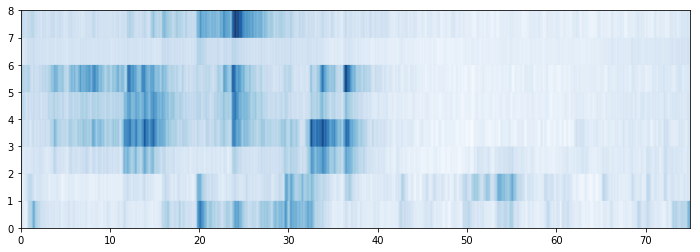

In [59]:
fig, axs = plt.subplots(1,1,figsize=(12,4))

axs.pcolor(time,np.arange(0,nclst),centroids2Plot,cmap='Blues', edgecolors='face')
fig.savefig(saveDir+sep+tiffName[:-4]+'_dffReordered_cluster_n{}.pdf'.format(nclst))

### Hierarchical clustering of ROIs

In [60]:
from sklearn.cluster import AgglomerativeClustering
supClust =  
cluster = AgglomerativeClustering(supClust, affinity='euclidean', linkage='ward')  
hclustLabs = cluster.fit_predict(centroids)  

SyntaxError: invalid syntax (<ipython-input-60-7d8bb893de48>, line 2)

In [ ]:
hclustLabs

In [ ]:
suplabsImg = kmlabsImg.copy()
for i in range(nclst):
    suplabsImg[kmlabsImg == i] = hclustLabs[i]

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(15,5), gridspec_kw={'width_ratios':[1,3]})


myClstMap = 'tab20b_r'
cNorm  = colors.Normalize(vmin=1, vmax=supClust)
supClstCMap = plt.cm.ScalarMappable(norm=cNorm,cmap=myClstMap)

axs[0].imshow(suplabsImg,cmap=myClstMap,origin='upper')
axs[0].axis('off')

for i in range(nclst):
    axs[1].plot(time,centroids[i]+hclustLabs[i], color=supClstCMap.to_rgba( hclustLabs[i]))
    axs[1].text(120,+hclustLabs[i]+.5,str(i),color=supClstCMap.to_rgba(hclustLabs[i]))
axs[1].set_xlabel('Time [s]')
axs[1].set_ylabel('DFF (+ 0.5*cluster ID)')
myAxisTheme(axs[1])

### ROIs on volume

In [161]:
dffStack4dMC.shape

(100, 10, 256, 256)

In [160]:
nclst = 9


toClust = dffStack4dMC[:,myMask>0]

kmeans = KMeans(n_clusters=nclst)
kmeans.fit(toClust.T)

IndexError: boolean index did not match indexed array along dimension 1; dimension is 10 but corresponding boolean dimension is 256

In [164]:
toVisStack4dDff = stack4dMC.reshape(dffStack4dMC.shape[0],dffStack4dMC.shape[1]*dffStack4dMC.shape[2],
                                    dffStack4dMC.shape[3])
toVisStack4dDff.shape

(100, 2560, 256)

In [166]:
windToVisStack4dDff = flw(np.max(toVisStack4dDff, axis=0))

AttributeError: 'NoneType' object has no attribute 'currentWindow'

In [ ]:
kmlabs = kmeans.predict(toClust.T)
centroids = kmeans.cluster_centers_

In [ ]:
myClstMap = 'tab20b_r'
cNorm  = colors.Normalize(vmin=1, vmax=nclst)
clstCMap = plt.cm.ScalarMappable(norm=cNorm,cmap=myClstMap)

time = np.linspace(0, stackMPMC.shape[0]/fpv, stackMPMC.shape[0])

In [ ]:
kmlabsImg = np.nan*np.ones(myMask.shape)

kmlabsImg[myMask>0] = kmlabs

fig, axs = plt.subplots(1,2,figsize=(15,5), gridspec_kw={'width_ratios':[1,3]})

axs[0].imshow(kmlabsImg,cmap=myClstMap,origin='upper')
axs[0].axis('off')

for i in range(nclst):
    axs[1].plot(time,centroids[i]+i, color=clstCMap.to_rgba(i+1))
    axs[1].text(120,+i+.5,str(i),color=clstCMap.to_rgba(i+1))
axs[1].set_xlabel('Time [s]')
axs[1].set_ylabel('DFF (+ 0.5*cluster ID)')
myAxisTheme(axs[1])

